In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import optimize
import pandas as pd
i = 0
#switching latex fonts
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})
plt.rcParams.update({
    "text.usetex": False,
    "font.family": 'fantasy',
    "font.fantasy": ['Arial', 'Times New Roman', 'Tahoma']})


In [39]:
x = np.array([
256.0,361.0,484.0,625.0,784.0,961.0,1156.0,1521.0,1764.0,2025.0,2304.0,169.0
])
y = np.array([
40.474485,44.28800000000001,48.672000000000004,53.59786801199999,59.56816728,66.195521388,73.25249903999999,86.71392784400001,95.503225823,105.05186009,115.60976497600001,36.62553387599999
])
xerr = np.array([
32.0,38.0,44.0,50.0,56.0,62.0,68.0,78.0,84.0,90.0,96.0,26.0
])
yerr = np.array([
3.2584050000000007,3.113600000000001,3.0576000000000003,3.05875596,3.1154905600000005,3.2047047600000003,3.3160478399999995,3.5470028900000004,3.70314741,3.8748144900000008,4.058298240000001,3.569614409999999
])


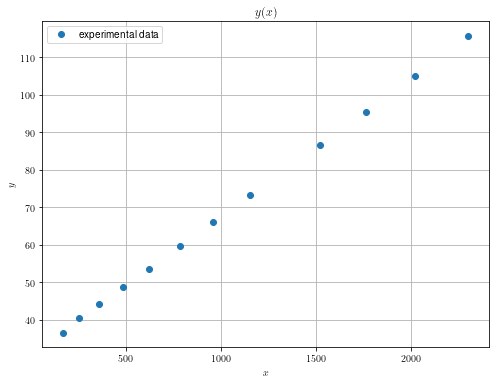

In [27]:
#simple visualization
plt.figure(figsize=(8, 6))
plt.plot(x, y, 'o', label="experimental data")
plt.grid(True)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title(r"$y(x)$")

plt.legend()

plt.savefig(f"viz{i}.png", dpi=200)
i+=1

0.03673763378764405 8.086669979233315e-05
30.80323483325391 0.10056446907836372


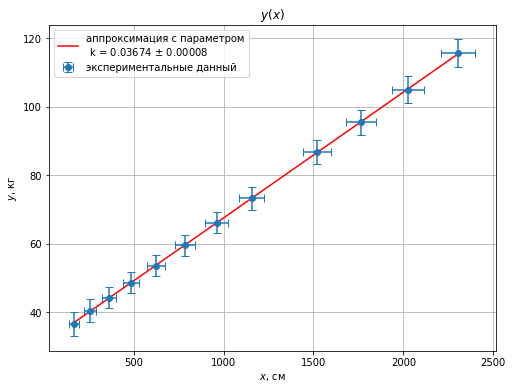

In [76]:
#simple approximation

def f(x, k, b):
    return b + k * x

from scipy.optimize import curve_fit
popt, pcov = curve_fit(f, x, y)
error = np.sqrt(np.diag(pcov))
for v, er in zip(popt, error):
    print(v, er)

plt.figure(figsize=(8, 6))
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данный", capsize=4, ms=6)
X = np.linspace(x.min(), x.max(), num=50)
pres = '0.5f'   # точность при форматировании
plt.plot(X, f(X, *popt), 'r', label=
f"аппроксимация с параметром\n k = {format(popt[0], pres)} $\pm$ {format(error[0], pres)}")

plt.grid(True)
plt.xlabel(r"$x$, см")
plt.ylabel(r"$y$, кг")
plt.title(r"$y(x)$")
plt.legend()

plt.savefig(f"opt{i}.png", dpi=200)
i+=1

0.03672112074854703 +- 0.0015203035125528855
30.825715939837174 +- 1.7275667912773514


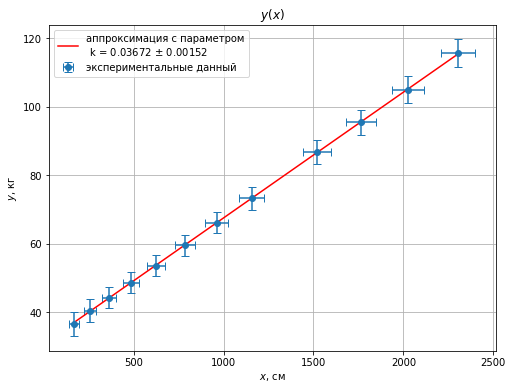

In [82]:
#xi square approximation with Y-errors

def f(x, k, b):
    return b + k * x

from scipy.optimize import curve_fit
popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True)
error = np.sqrt(np.diag(pcov))
for v, er in zip(popt, error):
    print(v,'+-',er)

plt.figure(figsize=(8, 6))
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данный", capsize=4, ms=6)
X = np.linspace(x.min(), x.max(), num=50)
pres = '0.5f'   # точность при форматировании
plt.plot(X, f(X, *popt), 'r', label=
f"аппроксимация с параметром\n k = {format(popt[0], pres)} $\pm$ {format(error[0], pres)}")

plt.grid(True)
plt.xlabel(r"$x$, см")
plt.ylabel(r"$y$, кг")
plt.title(r"$y(x)$")
plt.legend()

plt.savefig(f"opt{i}.png", dpi=200)
i+=1